In [1]:
from backtesting import *
from backtesting.lib import SignalStrategy, TrailingStrategy
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.lib import crossover, resample_apply
from collections import deque
import tensorflow as tf
import tensorflow.keras as keras
import math
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
def SIGNAL1():
    return df.signal1

def ATR():
    return df.atr

def Neural_Network(data, path, stats_dict, seq_len):

    # preprocess
    main_df = data.copy()
    for col in main_df.columns:  # go through all of the columns
        col_end = col.rsplit('_', -1)[-1]  # get the last word of the string
        if col == "Volume" or col_end == "volume":
            main_df[col] = (main_df[col].values - stats_dict[f'{col}']['mean']) / (stats_dict[f'{col}']['std'])

        elif col_end == "value":
            main_df[col] = (main_df[col].values - stats[f'{col}']['mean']) / (stats[f'{col}']['std'])

        elif col == "Open" or col == "High" or col == "Low" or col == "Close" or col_end == 'open'\
                or col_end == 'high' or col_end == 'low' or col_end == 'close' or col_end == "ma":
            main_df[col] = main_df[col].pct_change()
            main_df.dropna(inplace=True)
            main_df[col] = (main_df[col].values - stats_dict[f'{col}']['mean']) / (stats_dict[f'{col}']['std'])

    main_df.dropna(inplace=True)  # cleanup again

    main_df.dropna(inplace=True)
    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(
        maxlen=seq_len)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

    for i in main_df.values:  # iterate over the values
        prev_days.append([n for n in i[:]])  # store all but the target
        if len(prev_days) == seq_len:  # make sure we have 48 sequences!
            sequential_data.append(np.array(prev_days))  # append those bad boys!

    X = []
    for seq in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences

    final_data = np.array(X)

    model = tf.keras.models.load_model(path)
    predictions = model.predict(final_data)

    pred_list = []
    for pred in predictions:
        
        # Buy
        if (pred[2] > pred[0]) and (pred[2] > pred[1]):
            pred_list.append(2)
        # Sell
        elif (pred[0] > pred[2]) and (pred[0] > pred[1]):
            pred_list.append(0)
        # No trade
        else:
            pred_list.append(1)

            
    buy_list = []
    sell_list = []
    flat_list = []

    for pred in predictions:
        
        buy_list.append(pred[2])
        sell_list.append(pred[0])
        flat_list.append(pred[1])
            

      
    return pred_list, buy_list, sell_list, flat_list




In [3]:
# dataframe prep
df = pd.read_csv('/ETHPERP.csv')
df['startTime'] = pd.to_datetime(df['startTime'])
df.set_index('startTime', inplace=True)

day = 60*60*24
week = 60*60*24*7

df['Day_sin_value'] = np.sin(df['time'] * (2 * np.pi / day))
df['Day_cos_value'] = np.cos(df['time'] * (2 * np.pi / day))
df['Week_sin_value'] = np.sin(df['time'] * (2 * np.pi / week))
df['Week_cos_value'] = np.cos(df['time'] * (2 * np.pi / week))



df.drop(columns=['time'], inplace=True)
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
df = df.iloc[19000:] # Ensure we are operating on the testing set

model4_path = '/model.model'


stats = {'Day_cos_value': {'mean': 1.995848650470682e-05, 'std': 0.7071279506044719},
         'Day_sin_value': {'mean': 3.456911179592942e-05, 'std': 0.707113836978613},
         'Close': {'mean': 0.00013499451463623395, 'std': 0.010222616545887233},
         'High': {'mean': 0.00012189721875011916, 'std': 0.009010927715056327},
         'Low': {'mean': 0.00014861188842568972, 'std': 0.011457198801300696},
         'Open': {'mean': 0.0001339876181819151, 'std': 0.010219478504170286},
         'Volume': {'mean': 48690641.562491134, 'std': 78657724.08329752},
         'Week_cos_value': {'mean': 3.9471133265980576e-05, 'std': 0.7071074071009281},
         'Week_sin_value': {'mean': 5.94931587022028e-06, 'std': 0.7071343802953572},
         'AROOND_value': {'mean': 43.136321120591326, 'std': 35.213646675942485},
         'AROONOSC_value': {'mean': 4.729775972989004, 'std': 60.760526031702305},
         'AROONU_value': {'mean': 47.866097093580315, 'std': 35.90054836131416},  
         'slow_sma20_value': {'mean': 1510.3664712514994, 'std': 1413.6394359695923},
         'sma20_diff_value': {'mean': 0.5990493402638946, 'std': 49.468450562118264},
         'cmf_value': {'mean': 0.010835426903106684, 'std': 0.1545575427237255}}


# model_df
model4_df = df.copy()

# Model
model4_df.ta.aroon(high=model4_df['High'], low=model4_df['Low'], append=True)
model4_df.rename(columns={'AROOND_14': 'AROOND_value', 'AROONU_14': 'AROONU_value', 'AROONOSC_14': 'AROONOSC_value'}, inplace=True)
model4_df.dropna(inplace=True)

model4_df['slow_sma20_value'] = ta.sma(close=model4_df['Close'], length=20)
model4_df.dropna(inplace=True)
model4_df['sma20_diff_value'] = model4_df['Close'] - model4_df['slow_sma20_value']

model4_df['cmf_value'] = ta.cmf(high=model4_df['High'], low=model4_df['Low'], close=model4_df['Close'], volume=model4_df['Volume'], open_=model4_df['Open'])
model4_df.dropna(inplace=True)

In [4]:
pred, buy_list, sell_list, flat_list = Neural_Network(model4_df, model4_path, stats, 20)

df = df.iloc[(len(df)-len(pred)):]
df['signal1'] = pred
df['buy_signal'] = buy_list
df['sell_signal'] = sell_list
df['flat_signal'] = flat_list
df['atr'] = ta.atr(high=df['High'], low=df['Low'], close=df['Close'], append=True)
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,Day_sin_value,Day_cos_value,Week_sin_value,Week_cos_value,signal1,buy_signal,sell_signal,flat_signal,atr
startTime,,,,,,,,,,,,,,
2021-09-22 21:00:00+00:00,3027.2,3058.7,3012.4,3035.7,7.108453e+07,4.971210e-10,1.0,7.818315e-01,0.623490,2,0.854308,0.000110,0.145581,52.912076
2021-09-22 22:00:00+00:00,3035.7,3075.0,3029.2,3069.9,1.112721e+08,-8.660254e-01,-0.5,5.633201e-01,0.826239,2,0.905945,0.000014,0.094041,52.154960
2021-09-22 23:00:00+00:00,3069.9,3081.9,3048.5,3079.5,6.401959e+07,8.660254e-01,-0.5,2.947552e-01,0.955573,2,0.905199,0.000015,0.094787,50.225967
2021-09-23 00:00:00+00:00,3079.5,3099.8,3040.0,3044.2,1.644145e+08,-3.811349e-09,1.0,-5.444785e-10,1.000000,2,0.788929,0.000681,0.210389,51.180679
2021-09-23 01:00:00+00:00,3044.2,3077.0,3034.5,3071.4,6.421510e+07,-8.660254e-01,-0.5,-2.947552e-01,0.955573,2,0.790622,0.000654,0.208724,50.338866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27 09:00:00+00:00,1378.4,1386.2,1375.4,1384.5,4.837205e+07,-9.749850e-09,1.0,-7.818315e-01,0.623490,2,0.778883,0.000863,0.220255,14.727092
2022-09-27 10:00:00+00:00,1384.5,1389.3,1383.1,1386.9,4.495153e+07,-8.660254e-01,-0.5,-9.308737e-01,0.365341,2,0.754614,0.001475,0.243911,14.118014
2022-09-27 11:00:00+00:00,1386.9,1398.8,1381.7,1388.7,8.263855e+07,8.660254e-01,-0.5,-9.972038e-01,0.074730,2,0.742903,0.001881,0.255216,14.331013


In [5]:
class NeuralNet(Strategy):
    
    tp_factor = 3
    tp1_factor = 1
    sl_factor = 1.5
    lev = 10
    risk = 0.01


    def init(self):
        
        self.signal1 = self.I(SIGNAL1)
        self.atr = self.I(ATR)

    def next(self):
        
        
        tp_buy = self.data.Close[-1] + self.atr[-1]*self.tp_factor
        tp1_buy = self.data.Close[-1] + self.atr[-1]*self.tp1_factor
        sl_buy = self.data.Close[-1] - self.atr[-1]*self.sl_factor
        tp_sell = self.data.Close[-1] - self.atr[-1]*self.tp_factor
        tp1_sell = self.data.Close[-1] - self.atr[-1]*self.tp1_factor
        sl_sell = self.data.Close[-1] + self.atr[-1]*self.sl_factor
        acc_balance = self.equity
        
        position_size_buy = round((0.01*acc_balance)/(self.data.Close[-1] - sl_buy)/3)        
        position_size_sell = round((0.01*acc_balance)/(sl_sell - self.data.Close[-1])/3)
        
        
        # Buy
        if self.signal1[-1]==2:
            if self.signal1[-2] != 2 and not self.position.is_long:
                self.position.close()
                self.buy(size=position_size_buy, 
                        tp=tp_buy, 
                        sl=sl_buy)
                self.buy(size=position_size_buy, 
                        tp=tp1_buy, 
                        sl=sl_buy)
                self.buy(size=position_size_buy, 
                        sl=sl_buy)


            
        # Sell
        if self.signal1[-1]==0:
            if self.signal1[-2] != 0 and not self.position.is_short:
                self.position.close()
                self.sell(size=position_size_sell,
                        tp=tp_sell, 
                        sl=sl_sell)
                self.sell(size=position_size_sell,
                        tp=tp1_sell, 
                        sl=sl_sell)
                self.sell(size=position_size_sell,
                        sl=sl_sell)
                


        # closing trades
        if  self.position.is_long and (self.signal1[-1]==0):
            self.position.close()

        if self.position.is_short and (self.signal1[-1]==2):
            self.position.close()
            
            
        # managing open positions
        if self.position.is_long:
            if len(self.trades)==2:
                current_trade = self.trades[0]
                current_trade1 = self.trades[1]
                new_sl = current_trade.entry_price
                current_trade.sl = new_sl
                current_trade1.sl = new_sl

                
        if self.position.is_short:
            if len(self.trades)==2:
                current_trade = self.trades[0]
                current_trade1 = self.trades[1]
                new_sl = current_trade.entry_price
                current_trade.sl = new_sl
                current_trade1.sl = new_sl



bt = Backtest(df, NeuralNet, cash=100_000, commission=0.0007)

stats = bt.run()

print(stats)
bt.plot()

Start                     2021-09-22 21:00...
End                       2022-09-27 13:00...
Duration                    369 days 16:00:00
Exposure Time [%]                   74.912656
Equity Final [$]                139794.789101
Equity Peak [$]                 152768.948741
Return [%]                          39.794789
Buy & Hold Return [%]              -54.366373
Return (Ann.) [%]                   39.039446
Volatility (Ann.) [%]               33.238868
Sharpe Ratio                         1.174512
Sortino Ratio                        2.434696
Calmar Ratio                         2.483028
Max. Drawdown [%]                  -15.722515
Avg. Drawdown [%]                    -0.96201
Max. Drawdown Duration       64 days 21:00:00
Avg. Drawdown Duration        2 days 08:00:00
# Trades                                 1452
Win Rate [%]                        35.123967
Best Trade [%]                      19.751562
Worst Trade [%]                     -3.920837
Avg. Trade [%]                    

Row(id='1542', ...)

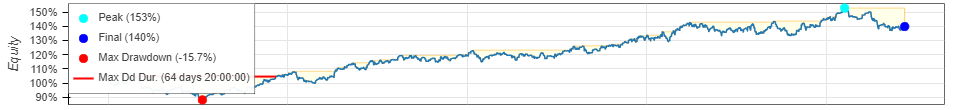

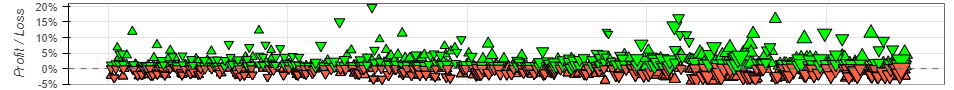

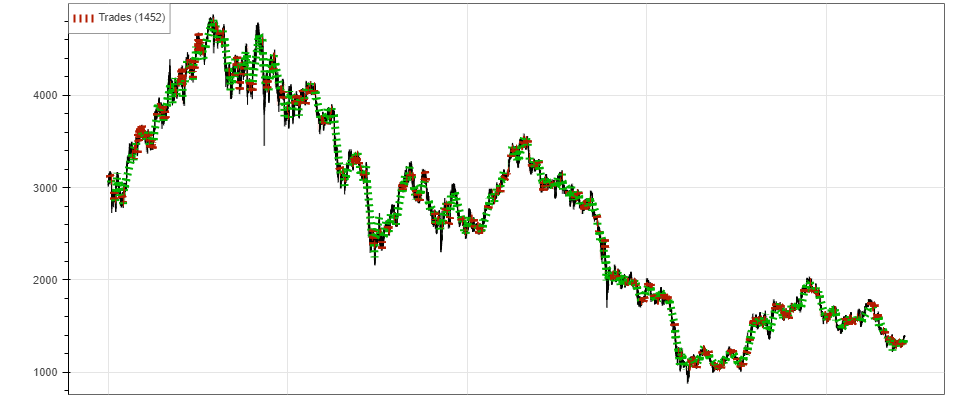

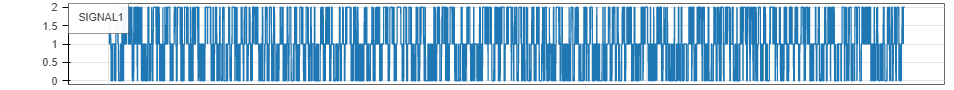

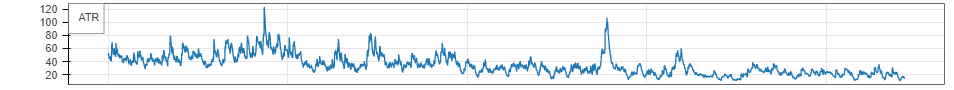